In [1]:
import os
import random
import time
import glob
import math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import intel_extension_for_pytorch as ipex
import torch.nn as nn
from torch import amp
from torch.optim.lr_scheduler import OneCycleLR

from sklearnex import patch_sklearn

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import (
    LabelEncoder,
    LabelBinarizer,
    StandardScaler,
)
from sklearn.impute import SimpleImputer
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    average_precision_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, EarlyStopping
import skorch.utils as sk_utils

# For inline plotting in Jupyter notebooks
%matplotlib inline

# Thread allocation for BLAS backends
env_threads = {
    "OMP_NUM_THREADS": "28",
    "MKL_NUM_THREADS": "28",
    "OPENBLAS_NUM_THREADS": "28",
    "DAAL_NUM_THREADS": "28",
}
for var, val in env_threads.items():
    os.environ[var] = val

# Global seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Patch sklearn to use Intel optimizations
patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
# -------------------------------
# Safe tensor-to-NumPy conversion
# -------------------------------
_old_to_numpy = sk_utils.to_numpy

def _to_numpy_safe(x):
    """
    Ensure bfloat16 tensors are cast to float32 before converting to numpy.
    """
    if isinstance(x, torch.Tensor) and x.dtype is torch.bfloat16:
        x = x.float()
    return _old_to_numpy(x)

sk_utils.to_numpy = _to_numpy_safe

# --------------------------------------
# Override predict_proba for NeuralNetClassifier
# --------------------------------------

def _predict_proba_safe(self, X):
    """
    Compute predict_proba on NumPy inputs, ensuring outputs
    are cast to float32 before conversion and concatenated correctly.
    """
    nonlin = self._get_predict_nonlinearity()
    outputs = []
    for yp in self.forward_iter(X, training=False):
        tensor = yp[0] if isinstance(yp, tuple) else yp
        prob = nonlin(tensor).float()
        outputs.append(prob)
    return torch.cat(outputs, dim=0).cpu().numpy()

NeuralNetClassifier.predict_proba = _predict_proba_safe



In [3]:
# --------------------------------------
# Plotting utilities
# --------------------------------------

def plot_class_distribution(data, label=None, title=None, ax=None):
    """
    Plot a bar chart of class counts.

    Parameters
    ----------
    data   : pd.DataFrame | pd.Series | np.ndarray | list
        Either a full dataframe that contains the label column,
        or the label vector itself.
    label  : str | int | None
        Column name (or index) of the label if `data` is a dataframe.
        Ignored when `data` is already a 1-D label vector.
    title  : str
        Optional title for the plot.
    ax     : matplotlib Axes
        Plot onto an existing axis (useful for subplots).
    """
    if isinstance(data, pd.DataFrame):
        if label is None:
            raise ValueError("Please specify `label=` when passing a DataFrame.")
        y = data[label]
    else:
        y = pd.Series(data)

    counts = y.value_counts().sort_index()
    total = counts.sum()

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(
        x=counts.index.astype(str),
        y=counts.values,
        hue=counts.index.astype(str),
        palette='viridis',
        dodge=False,
        legend=False,
        ax=ax,
    )
    ax.set_ylabel("count")
    ax.set_xlabel(label if label else "label")
    ax.set_title(title or "Class distribution")

    # Annotate bars with count and percentage
    for bar in ax.patches:
        h = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        ax.text(
            x,
            h + max(counts.values) * 0.01,
            f"{int(h):,}\n({h/total*100:.1f}%)",
            ha='center',
            va='bottom',
            fontsize=9,
        )

    plt.tight_layout()
    return ax


def tidy_axis(ax, rotation=45, fontsize=6):
    """
    Apply consistent formatting to an axis: rotate x-ticks and set label size.
    """
    ax.tick_params(axis='x', rotation=rotation, labelsize=fontsize)
    plt.tight_layout()
    return ax

In [4]:
# --------------------------------------
# Resampling pipelines
# --------------------------------------

def make_realistic_resampler(y_train, under_frac=0.8, smote_frac=0.8, singleton_target=15):
    """
    Build a sampling-plus-preprocess pipeline that is *leak-safe*:
    - mean impute → scale → RUS → ROS(singletons) → SMOTE → TomekLinks
    All resampling ratios are computed from y_train only.
    """
    ctr = Counter(y_train)

    # 1) Controlled undersampling of the majority class
    maj_label, maj_count = ctr.most_common(1)[0]
    target_maj = int(under_frac * maj_count)
    rus = RandomUnderSampler(
        sampling_strategy={maj_label: target_maj},
        random_state=SEED
    )

    # 2) Give every singleton at least `singleton_target` examples
    ros = RandomOverSampler(
        sampling_strategy={lbl: singleton_target for lbl, c in ctr.items() if c == 1},
        random_state=SEED
    )

    # Peek at post-ROS counts so SMOTE knows its targets
    _, y_tmp = ros.fit_resample(
        *rus.fit_resample(np.zeros_like(y_train).reshape(-1, 1), y_train)
    )
    post_ctr = Counter(y_tmp)
    _, post_maj_count = post_ctr.most_common(1)[0]

    # 3) SMOTE the still-minor classes up to ≤ smote_frac of majority
    smote_strat = {}
    for cls, cnt in post_ctr.items():
        if cls == maj_label:
            continue
        raw_target = min(int(smote_frac * post_maj_count), cnt * 3)
        if raw_target > cnt:
            smote_strat[cls] = raw_target

    k = max(1, min(5, min(post_ctr.values()) - 1))
    sm = SMOTE(
        sampling_strategy=smote_strat,
        k_neighbors=k,
        random_state=SEED
    )

    # 4) Full leakage-safe pipeline
    return ImbPipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler()),
        ('under', rus),
        ('ros1', ros),
        ('smote', sm),
        ('clean', TomekLinks())
    ])


def make_kdd_sampler(y_train):
    """
    KDD-specific sampler: custom under/SMOTE fractions.
    """
    return make_realistic_resampler(y_train, under_frac=0.3, smote_frac=0.4)

In [5]:
# --------------------------------------
# Probability alignment utility
# --------------------------------------

def align_probabilities(y_test, probas, model_classes):
    """
    Align modeled probabilities to the ground-truth label order.
    Returns binarized y and aligned probability matrix.
    """
    lb = LabelBinarizer().fit(model_classes)
    y_bin = lb.transform(y_test)

    # Handle binary case
    if y_bin.ndim == 1:
        y_bin = np.vstack([1 - y_bin, y_bin]).T
        probas = np.vstack([1 - probas, probas]).T

    # Re-order/drop probability columns so they match classes
    aligned = np.zeros_like(y_bin, dtype=float)
    class_to_idx = {cls: idx for idx, cls in enumerate(model_classes)}
    for col_idx, cls in enumerate(model_classes):
        aligned[:, class_to_idx[cls]] = probas[:, col_idx]

    return y_bin, aligned


In [6]:
# --------------------------------------
# Training & evaluation utilities
# --------------------------------------

def train_and_evaluate(models, X_train, y_train_semi, X_test, y_test, dataset_name):
    """
    Train and evaluate semi-supervised and supervised classifiers.
    Returns a dict of performance metrics per model.
    """
    print(f"\n=== {dataset_name} ===\nSemi-Supervised Classification\n{'-'*40}")
    results = {}

    # Build a purely-labeled subset for fully-supervised baselines
    sup_mask = (y_train_semi != -1)
    X_sup, y_sup = X_train[sup_mask], y_train_semi[sup_mask]

    for name, clf in models.items():
        t0 = time.time()

        # Fit on the right target
        if isinstance(clf, SelfTrainingClassifier):
            clf.fit(X_train, y_train_semi)
        else:
            clf.fit(X_sup, y_sup)

        duration = time.time() - t0

        # Predictions and class checks
        y_pred = clf.predict(X_test)
        print("Classes in y_test:", np.unique(y_test))
        print("Classes predicted:", np.unique(y_pred))
        missing = set(np.unique(y_test)) - set(np.unique(y_pred))
        print("Classes with no predictions:", missing)

        # Classification report
        report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

        print(f"\n--- {name} ---")
        print(classification_report(y_test, y_pred, zero_division=0))

        df_rpt = pd.DataFrame(report).T
        fname = f"{dataset_name}_{name.replace(' ', '_')}_class_report.csv"
        df_rpt.to_csv(os.path.join("/home/cwtgl", fname), index=True)
        print(f"Saved full report to {fname}")

        # PR-AUC & ROC-AUC
        classes = np.unique(y_test)
        probas = clf.predict_proba(X_test)
        if len(classes) == 2:
            positive = probas[:, 1]
            print("Binary PR-AUC:", average_precision_score(y_test, positive))
            print("Binary ROC-AUC:",  roc_auc_score(y_test, positive))
        else:
            model_classes = clf.classes_
            y_bin, aligned_probas = align_probabilities(y_test, probas, model_classes)
            print("Macro PR-AUC:", average_precision_score(y_bin, aligned_probas, average='macro'))
            print("Macro ROC-AUC:",  roc_auc_score(y_bin, aligned_probas, average='macro', multi_class='ovo'))

        print(f"{name} trained in {duration:.2f}s.")

        results[name] = {
            "accuracy": report["accuracy"],
            "precision": report["macro avg"]["precision"],
            "recall": report["macro avg"]["recall"],
            "f1_score": report["macro avg"]["f1-score"],
            "training_time_seconds": duration
        }

    return results


In [7]:
# --------------------------------------
# Label detection & loading
# --------------------------------------

def find_label_column(columns, preferred=("label","class","target")):
    """Return first matching lower-case name or last column."""
    for col in columns[::-1]:
        if col.lower() in preferred: return col
    return columns[-1]

# Data Loading & Preprocessing
def load_and_preprocess_cicids(filepath):
    df=pd.read_csv(filepath, low_memory=False)
    target=find_label_column(df.columns)
    plot_class_distribution(df,label=target,title="Raw CICIDS2017")
    df.replace('-',np.nan,inplace=True)
    features=df.columns.drop(target)
    df[features]=df[features].apply(pd.to_numeric,errors='coerce')
    df[target] = df[target].fillna(df[target].mode(dropna=True)[0])
    X=df[features].to_numpy(np.float32); y=df[target].to_numpy()
    le=LabelEncoder().fit(y); return X,le.transform(y),le.classes_

def load_and_preprocess_kdd(filepath):
    df=pd.read_csv(filepath, low_memory=False)
    target=find_label_column(df.columns)
    plot_class_distribution(df,label=target,title="Raw KDD")
    df.replace('-',np.nan,inplace=True)
    features=df.columns.drop(target)
    df[features]=df[features].apply(pd.to_numeric,errors='coerce')
    df[target] = df[target].fillna(df[target].mode(dropna=True)[0])
    X=df[features].to_numpy(np.float32); y=df[target].to_numpy()
    le=LabelEncoder().fit(y); return X,le.transform(y),le.classes_

def load_and_preprocess_unsw(filepath):
    df=pd.read_csv(filepath,low_memory=False)
    target=find_label_column(df.columns)
    plot_class_distribution(df,label=target,title="Raw UNSW")
    df.replace('-',np.nan,inplace=True)
    features=df.columns.drop(target)
    df[features]=df[features].apply(pd.to_numeric,errors='coerce')
    df[features] = df[features].fillna(0)
    df[target] = df[target].fillna(df[target].mode(dropna=True)[0])
    X=df[features].to_numpy(np.float32); y=df[target].to_numpy()
    le=LabelEncoder().fit(y); return X,le.transform(y),le.classes_


In [8]:
# --------------------------------------
# Neural network model definitions
# --------------------------------------

# b) Slightly deeper fully connected network
class SimpleMLP(nn.Module):
    def __init__(self, n_in, n_out, hidden=(256, 128), p=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, hidden[0]), nn.ReLU(), nn.Dropout(p),
            nn.Linear(hidden[0], hidden[1]), nn.ReLU(), nn.Dropout(p),
            nn.Linear(hidden[1], n_out)
        )
    def forward(self, x):
        return self.net(x)

class IpexNetClassifier(NeuralNetClassifier):
    """NeuralNetClassifier + Intel® Extension for PyTorch speed-ups."""

    def initialize_module(self, *args, **kwargs):
        super().initialize_module(*args, **kwargs)
        # Uncomment to compile with TorchDynamo + IPEX
        # self.module_ = torch.compile(self.module_, backend="ipex")
        return self

    def initialize_optimizer(self, *args, **kwargs):
        super().initialize_optimizer(*args, **kwargs)
        self.module_, self.optimizer_ = ipex.optimize(
            self.module_,
            optimizer=self.optimizer_,
            dtype=torch.bfloat16,
            level="O1",
            inplace=True,
            auto_kernel_selection=True
        )
        return self

    def train_step_single(self, batch, **fit_params):
        with torch.autocast("cpu", dtype=torch.bfloat16):
            return super().train_step_single(batch, **fit_params)

    def validation_step(self, batch, **fit_params):
        with torch.autocast("cpu", dtype=torch.bfloat16):
            return super().validation_step(batch, **fit_params)

    def evaluation_step(self, batch, training=False):
        with torch.autocast("cpu", dtype=torch.bfloat16):
            return super().evaluation_step(batch, training=training)

In [9]:
# --------------------------------------
# Model factory utilities
# --------------------------------------

def make_ipex_mlp(
    n_features: int,
    n_classes:  int,
    *,
    device: str      = "cpu",
    criterion       = None,
    max_epochs: int  = 40,
    lr: float        = 5e-3,
    batch_size: int  = 4096,
    num_workers: int = 6,
    extra_callbacks = None,
):
    """
    Build a skorch-based MLP that is:
      • Intel IPEX-optimised (BF16 + fused AdamW)
      • compiled once with torch.compile(..., backend='ipex')
      • fed by DataLoaders that keep workers alive between epochs
    """
    def _steps_per_epoch(n):
        return math.ceil(n / batch_size)

    return IpexNetClassifier(
        module                  = SimpleMLP,
        module__n_in            = n_features,
        module__n_out           = n_classes,
        max_epochs              = max_epochs,
        lr                      = lr,
        batch_size              = batch_size,
        criterion               = criterion or nn.CrossEntropyLoss(),
        optimizer               = torch.optim.AdamW,
        iterator_train__shuffle = True,
        iterator_train__num_workers = num_workers,
        device                  = device,
        callbacks               = (extra_callbacks or []) + [
            ("early_stop", EarlyStopping(patience=8, monitor="valid_loss")),
        ],
    )


In [10]:
class FixedClassWrapper(BaseEstimator, ClassifierMixin):
    """
    Wraps an arbitrary classifier so that:

      1. `classes_` is always the full range [0 … n_total-1].
      2. `predict_proba` returns a matrix with exactly n_total columns,
         ordered from class 0 up to class n_total-1.
    """

    def __init__(self, base_estimator, n_total: int):
        self.base_estimator = base_estimator
        self.n_total = n_total

    def fit(self, X, y):
        """Fit the underlying estimator and build a full `classes_` array."""
        self.base_estimator.fit(X, y)
        seen = list(self.base_estimator.classes_)
        missing = [c for c in range(self.n_total) if c not in seen]
        # classes_ must be in ascending order
        self.classes_ = np.array(seen + missing, dtype=int)
        return self

    def predict(self, X):
        """Delegate prediction to the wrapped estimator."""
        return self.base_estimator.predict(X)

    def predict_proba(self, X):
        """
        Get probabilities for the existing classes, then pad
        with zeros so the result has shape (n_samples, n_total).
        """
        probs = self.base_estimator.predict_proba(X)
        n_samples = probs.shape[0]
        full_probs = np.zeros((n_samples, self.n_total), dtype=probs.dtype)

        for idx, cls in enumerate(self.base_estimator.classes_):
            full_probs[:, cls] = probs[:, idx]

        return full_probs

    def get_params(self, deep=True):
        """
        Return parameters for this estimator.
        `deep` is ignored since we only expose top-level params.
        """
        return {"base_estimator": self.base_estimator, "n_total": self.n_total}

    def set_params(self, **params):
        """
        Set parameters on this wrapper or pass them down to
        the wrapped estimator.
        """
        if "base_estimator" in params:
            self.base_estimator = params.pop("base_estimator")
        if "n_total" in params:
            self.n_total = params.pop("n_total")
        # anything left is for the base estimator
        if params:
            self.base_estimator.set_params(**params)
        return self

In [11]:
def cross_validated_workflow(
    X,
    y,
    dataset_name: str,
    sampler_fn,
    n_splits: int = 5,
    sample_frac: float = 1.0,
) -> pd.DataFrame:
    """
    Perform a 5-fold CV that is leak-safe even with label-driven samplers.
    Returns a DataFrame of mean/std metrics aggregated across folds.
    """
    # — optionally downsample once up front —
    if sample_frac < 1.0:
        rng = np.random.default_rng(SEED)
        sample_size = int(len(X) * sample_frac)
        indices = rng.choice(len(X), size=sample_size, replace=False)
        X, y = X[indices], y[indices]
        print(f"[{dataset_name}] downsampled to {sample_size} rows.")

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    fold_metrics = defaultdict(list)

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        print(f"\n=== {dataset_name} · Fold {fold_idx}/{n_splits} ===")
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # visualize before/after only on first & last fold
        if fold_idx in {1, n_splits}:
            plot_class_distribution(
                pd.Series(y_train, name="label"),
                title=f"{dataset_name} · Fold{fold_idx} TRAIN (pre-resample)"
            )

        # build and apply sampler
        pipeline = sampler_fn(y_train)
        X_train_rs, y_train_rs = pipeline.fit_resample(X_train, y_train)
        X_train = X_train_rs.astype(np.float32)

        if fold_idx in {1, n_splits}:
            plot_class_distribution(
                pd.Series(y_train_rs, name="label"),
                title=f"{dataset_name} · Fold{fold_idx} TRAIN (post-resample)"
            )

        # prepare callbacks for MLP
        steps_per_epoch = math.ceil(len(X_train) / 4096)
        onecycle_cb = (
            "one_cycle",
            LRScheduler(
                policy=OneCycleLR,
                max_lr=5e-3,
                epochs=40,
                steps_per_epoch=steps_per_epoch,
                pct_start=0.05,
                div_factor=25.0,
                step_every="batch",
            )
        )

        # preprocess test set with same imputer/scaler
        X_test = pipeline.named_steps['impute'].transform(X_test)
        X_test = pipeline.named_steps['scale'].transform(X_test)
        X_test = X_test.astype(np.float32)

        # mask half the labels for semi-supervised learning
        mask = np.random.RandomState(SEED).rand(len(y_train_rs)) < 0.5
        y_train_semi = y_train_rs.copy()
        y_train_semi[mask] = -1

        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train_rs))

        # define semi-supervised models
        def make_semi(base_clf):
            wrapped = FixedClassWrapper(base_clf, n_total=n_classes)
            return SelfTrainingClassifier(wrapped)

        semi_rf = make_semi(RandomForestClassifier(n_estimators=1000,class_weight="balanced_subsample",n_jobs=-1,random_state=SEED))
        semi_lr = make_semi(LogisticRegression(max_iter=1000,class_weight="balanced",n_jobs=-1,random_state=SEED))
        base_mlp = (make_ipex_mlp(n_features,n_classes,extra_callbacks=[onecycle_cb]).initialize())
        base_mlp.module_ = torch.compile(base_mlp.module_, backend="ipex")
        semi_mlp = SelfTrainingClassifier(estimator=base_mlp,max_iter=3,threshold=0.75,verbose=False,)

        models = {
            "Random Forest": semi_rf,
            "LogReg":        semi_lr,
            "MLP":           semi_mlp,
        }

        # add supervised baselines (no resampling, no SSL)
        supervised = {
            "Dummy Majority": DummyClassifier(strategy='most_frequent', random_state=SEED),
            "Gaussian NB": GaussianNB(),
            "RF (no RS)": RandomForestClassifier(n_estimators=1000,class_weight='balanced_subsample',n_jobs=-1,random_state=SEED),
            "LogReg (no RS)": LogisticRegression(max_iter=1000,class_weight='balanced',n_jobs=-1,random_state=SEED),}
        for name, clf in supervised.items():
            models[name] = clone(clf)

        # evaluate all models and collect metrics
        fold_results = train_and_evaluate(models,X_train,y_train_semi,X_test,y_test,f"{dataset_name}-fold{fold_idx}")
        for (model_name, metric), value in [
            ((m, k), v) for m, metrics in fold_results.items() for k, v in metrics.items()
        ]:
            fold_metrics[(model_name, metric)].append(value)

    # aggregate across folds
    summary = [
        {
            "Model":  model_name,
            "Metric": metric,
            "Mean":   np.mean(vals),
            "Std":    np.std(vals),
        }
        for (model_name, metric), vals in fold_metrics.items()
    ]

    return pd.DataFrame(summary)


=== CICIDS2017 · Fold 1/5 ===

=== CICIDS2017-fold1 ===
Semi-Supervised Classification
----------------------------------------
Classes in y_test: [0 1 2 3 4 5 6 7]
Classes predicted: [0 1 2 3 4 6 7]
Classes with no predictions: {np.int64(5)}

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63634
           1       0.68      0.78      0.73        72
           2       1.00      1.00      1.00      3029
           3       1.00      1.00      1.00       281
           4       0.99      1.00      1.00      4702
           5       0.00      0.00      0.00         1
           6       1.00      0.98      0.99       110
           7       1.00      1.00      1.00      9191

    accuracy                           1.00     81020
   macro avg       0.83      0.84      0.84     81020
weighted avg       1.00      1.00      1.00     81020

Saved full report to CICIDS2017-fold1_Random_Forest_class_report.csv
Macro PR-AUC:

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0649       0.0341        2.0645  6.5836
      2        2.0651       0.0341        2.0645  4.0909
      3        2.0645       0.0341        2.0645  5.1168
      4        2.0649       0.0341        2.0645  4.7435
      5        2.0649       0.0341        2.0645  4.2667
      6        2.0651       0.0341        2.0645  4.0757
      7        2.0649       0.0341        2.0645  4.6998
      8        2.0649       0.0341        2.0645  4.4899
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0687       0.0249        2.0687  4.4652
      2        2.0695       0.0249        2.0687  4.1169
      3        2.0692       0.0249        2.0687  3.3501
      4        2.0694       0.0249        2.0687  4.9846
      5        2.0687       0.0249        2.0687  3.8701
      6        2.0696       0.0249        2.0687  4.0268
      7        2.0691       0.0249        2.0687  4.2161
      8        2.0690       0.0249        2.0687  4.0873
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1165       0.0292        2.1135  3.9181
      2        2.1167       0.0292        2.1135  4.7378
      3        2.1167       0.0292        2.1135  3.1338
      4        2.1169       0.0292        2.1135  3.3109
      5        2.1171       0.0292        2.1135  5.0962
      6        2.1168       0.0292        2.1135  6.7130
      7        2.1167       0.0292        2.1135  4.5506
      8        2.1170       0.0292        2.1135  5.6467
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.1036       0.0770        2.1000  4.4739
      2        2.1036       0.0770        2.1000  4.6199
      3        2.1038       0.0770        2.1000  3.5770
      4        2.1037       0.0770        2.1000  3.7078
      5        2.1036       0.0770        2.1000  3.3819
      6        2.1042       0.0770        2.1000  4.3484
      7        2.1040       0.0770        2.1000  3.5902
      8        2.1040       0.0770        2.1000  3.5456
Stopping since valid_loss has not improved in the last 8 epochs.
Classes in y_test: [0 1 2 3 4 5 6 7]
Classes predicted: [0 1 2 3 4 5 6]
Classes with no predictions: {np.int64(7)}

--- MLP ---
              precision    recall  f1-score   support

           0       0.55      0.01      0.02     63633
           1       0.00      0.04      0.00        72
           2       0.03      0.01      0.02      3029
           3       0

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



=== KDD-fold1 ===
Semi-Supervised Classification
----------------------------------------
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 18 19 20 21 23 24 25 26 27
 28 29 32 34 35 37]
Classes with no predictions: {np.int64(33), np.int64(3), np.int64(38), np.int64(39), np.int64(9), np.int64(17), np.int64(22), np.int64(30)}

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       1.00      1.00      1.00       263
           2       0.75      0.60      0.67        10
           3       0.00      0.00      0.00         2
           4       0.97      0.99      0.98       257
           5       0.55      0.81      0.66        26
           6       1.00      0.50      0.67         2
           7       0.90      0.97      0.93       748
           

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg ---
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       147
           1       0.81      0.62      0.70       263
           2       0.07      0.40      0.12        10
           3       0.00      0.00      0.00         2
           4       0.07      0.20      0.10       257
           5       0.04      0.77      0.07        26
           6       0.03      0.50      0.06         2
           7       0.74      0.68      0.71       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.07      0.62      0.12        58
          11       0.2

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.3187786042690298
Macro ROC-AUC: nan
LogReg trained in 613.51s.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.6879       0.0022        3.6746  1.0571
      2        3.6862       0.0022        3.6746  1.1536
      3        3.6876       0.0022        3.6746  1.1314
      4        3.6877       0.0022        3.6746  1.0390
      5        3.6879       0.0022        3.6746  0.8938
      6        3.6869       0.0022        3.6746  1.1545
      7        3.6883       0.0022        3.6746  1.1108
      8        3.6868       0.0022        3.6746  1.4740
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7364       0.0009        3.7322  1.1690
      2        3.7370       0.0009        3.7322  1.0016
      3        3.7358       0.0009        3.7322  1.5337
      4        3.7351       0.0009        3.7322  1.1415
      5        3.7363       0.0009        3.7322  1.1436
      6        3.7355       0.0009        3.7322  0.9769
      7        3.7358       0.0009        3.7322  1.2345
      8        3.7371       0.0009        3.7322  1.9363
Stopping since valid_loss has not improved in the last 8 epochs.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  7 16 18 20 23 25 27 32 33 35 36 37 38 39]
Classes with no predictions: {np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(11), n

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.04811462920508856
Macro ROC-AUC: nan
MLP trained in 23.97s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [14]
Classes with no predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(37), np.int64(38), np.int64(39)}

--- Dummy Majority ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.00      0.00      0.00       263
           2       0.00      0.00      

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro ROC-AUC: nan
Dummy Majority trained in 0.00s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 32 34 35 37 38 39]
Classes with no predictions: {np.int64(17), np.int64(30), np.int64(33)}

--- Gaussian NB ---
              precision    recall  f1-score   support

           0       0.10      0.99      0.18       147
           1       0.93      0.97      0.95       263
           2       0.02      0.20      0.03        10
           3       0.00      0.00      0.00         2
           4       0.13      0.07      0.09       257
           5       0.00      0.00      0.00        26
           6       0.05      0.50      0.09         2
           7       0.52      0.84      0.64       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00        

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.2958651695237772
Macro ROC-AUC: nan
Gaussian NB trained in 0.02s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 18 19 20 21 23 24 25 26 27
 28 29 30 32 34 35 37]
Classes with no predictions: {np.int64(33), np.int64(3), np.int64(38), np.int64(39), np.int64(9), np.int64(17), np.int64(22)}

--- RF (no RS) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       1.00      1.00      1.00       263
           2       0.67      0.60      0.63        10
           3       0.00      0.00      0.00         2
           4       0.97      0.99      0.98       257
           5       0.54      0.81      0.65        26
           6       1.00      0.50      0.67         2
           7       0.90      0.96      0.93       748
           8       1.00      1.00 

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg (no RS) ---
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       147
           1       0.79      0.67      0.73       263
           2       0.08      0.40      0.13        10
           3       0.00      0.00      0.00         2
           4       0.06      0.18      0.09       257
           5       0.04      0.77      0.08        26
           6       0.04      0.50      0.08         2
           7       0.75      0.67      0.71       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.07      0.60      0.13        58
          11  

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.3147584994832478
Macro ROC-AUC: nan
LogReg (no RS) trained in 30.99s.

=== KDD · Fold 2/5 ===


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



=== KDD-fold2 ===
Semi-Supervised Classification
----------------------------------------
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 17 19 20 21 23 24 25 26 27
 28 29 32 34 35]
Classes with no predictions: {np.int64(33), np.int64(3), np.int64(37), np.int64(38), np.int64(39), np.int64(9), np.int64(18), np.int64(22), np.int64(30)}

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       1.00      1.00      1.00       263
           2       0.50      0.80      0.62        10
           3       0.00      0.00      0.00         2
           4       0.99      0.97      0.98       257
           5       0.80      0.62      0.70        26
           6       1.00      1.00      1.00         2
           7       0.90      0.96      0.93       748


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg ---
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       147
           1       0.63      0.60      0.61       263
           2       0.00      0.00      0.00        10
           3       0.01      0.50      0.01         2
           4       0.12      0.35      0.18       257
           5       0.03      0.77      0.05        26
           6       0.12      1.00      0.21         2
           7       0.77      0.73      0.75       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.08      0.69      0.14        59
          11       0.1

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.30016754596567125
Macro ROC-AUC: nan
LogReg trained in 538.74s.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7405       0.0005        3.7264  2.0016
      2        3.7397       0.0005        3.7264  1.9497
      3        3.7404       0.0005        3.7264  1.8151
      4        3.7398       0.0005        3.7264  1.3493
      5        3.7399       0.0005        3.7264  1.8302
      6        3.7407       0.0005        3.7264  1.1869
      7        3.7402       0.0005        3.7264  1.3817
      8        3.7403       0.0005        3.7264  2.2548
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.6689       0.0509        3.6711  1.5386
      2        3.6692       0.0509        3.6711  1.4243
      3        3.6683       0.0509        3.6711  1.3585
      4        3.6692       0.0509        3.6711  1.0901
      5        3.6689       0.0509        3.6711  0.9835
      6        3.6691       0.0509        3.6711  1.4195
      7        3.6690       0.0509        3.6711  1.1398
      8        3.6688       0.0509        3.6711  1.8001
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7365       0.0000        3.7285  1.9916
      2        3.7361       0.0000        3.7285  2.9001
      3        3.7363       0.0000        3.7285  1.5613
      4        3.7369       0.0000        3.7285  1.2458
      5        3.7370       0.0000        3.7285  1.3365
      6        3.7364       0.0000        3.7285  1.5143
      7        3.7368       0.0000        3.7285  1.1452
      8        3.7365       0.0000        3.7285  1.6686
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.6870       0.0017        3.6829  1.8895
      2        3.6879       0.0017        3.6829  2.1013
      3        3.6877       0.0017        3.6829  1.4318
      4        3.6888       0.0017        3.6829  1.2669
      5        3.6879       0.0017        3.6829  1.2492
      6        3.6876       0.0017        3.6829  1.8904
      7        3.6874       0.0017        3.6829  1.6470
      8        3.6886       0.0017        3.6829  1.8642
Stopping since valid_loss has not improved in the last 8 epochs.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  4  8 11 12 13 14 16 17 19 21 23 24 25 27 29 32 33 34 37 39]
Classes with no predictions: {np.int64(2), np.int64(3), np.int64(35), np.int64(5), np.int64(6), np.int64(7), np.int64(38), np.int64(9), np.int

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Macro PR-AUC: 0.027776554447585495
Macro ROC-AUC: nan
MLP trained in 62.55s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [14]
Classes with no predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(37), np.int64(38), np.int64(39)}

--- Dummy Majority ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.00      0.00      0.00       263
           2       0.00      0.00     

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro ROC-AUC: nan
Dummy Majority trained in 0.00s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 25 26 27 28 29 32 34 35 37 39]
Classes with no predictions: {np.int64(38), np.int64(33), np.int64(18), np.int64(30)}

--- Gaussian NB ---
              precision    recall  f1-score   support

           0       0.12      0.99      0.22       147
           1       0.69      1.00      0.82       263
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         2
           4       0.18      0.04      0.07       257
           5       0.00      0.00      0.00        26
           6       0.05      1.00      0.10         2
           7       0.64      0.84      0.73       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.29639908788997504
Macro ROC-AUC: nan
Gaussian NB trained in 0.02s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 17 19 20 21 23 24 25 26 27
 28 29 32 34 35 37]
Classes with no predictions: {np.int64(33), np.int64(3), np.int64(38), np.int64(39), np.int64(9), np.int64(18), np.int64(22), np.int64(30)}

--- RF (no RS) ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       1.00      1.00      1.00       263
           2       0.50      0.80      0.62        10
           3       0.00      0.00      0.00         2
           4       0.98      0.97      0.97       257
           5       0.76      0.62      0.68        26
           6       1.00      1.00      1.00         2
           7       0.90      0.95      0.92       748
           8       1.0

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg (no RS) ---
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       147
           1       0.66      0.65      0.66       263
           2       0.05      0.30      0.08        10
           3       0.00      0.50      0.00         2
           4       0.10      0.26      0.15       257
           5       0.03      0.69      0.06        26
           6       0.07      1.00      0.13         2
           7       0.78      0.71      0.75       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.09      0.68      0.15        59
          11  

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.3066917893657747
Macro ROC-AUC: nan
LogReg (no RS) trained in 33.79s.

=== KDD · Fold 3/5 ===

=== KDD-fold3 ===
Semi-Supervised Classification
----------------------------------------
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 34 35 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 17 19 20 21 23 24 25 26 27
 28 29 32 34 35 39]
Classes with no predictions: {np.int64(3), np.int64(37), np.int64(38), np.int64(9), np.int64(18), np.int64(22)}

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       263
           2       0.73      0.80      0.76        10
           3       0.00      0.00      0.00         2
           4       0.98      0.99      0.99       257
           5       0.73      0.59      0.65        27
           6       1.00      0.67      0.80

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/me

Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg ---
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       148
           1       0.80      0.56      0.66       263
           2       0.05      0.50      0.09        10
           3       0.00      0.50      0.00         2
           4       0.09      0.29      0.14       257
           5       0.04      0.93      0.08        27
           6       0.09      0.67      0.15         3
           7       0.78      0.72      0.75       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.07      0.64      0.13        59
          11       0.17     

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/me

Macro PR-AUC: 0.37087455703401034
Macro ROC-AUC: nan
LogReg trained in 709.04s.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.6950       0.0143        3.6870  1.9590
      2        3.6949       0.0143        3.6870  1.3956
      3        3.6946       0.0143        3.6870  1.8226
      4        3.6946       0.0143        3.6870  2.4600
      5        3.6952       0.0143        3.6870  1.6872
      6        3.6949       0.0143        3.6870  1.9856
      7        3.6947       0.0143        3.6870  1.9777
      8        3.6949       0.0143        3.6870  1.8251
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7353       0.0227        3.7267  1.4042
      2        3.7353       0.0227        3.7267  1.4680
      3        3.7343       0.0227        3.7267  1.6318
      4        3.7355       0.0227        3.7267  2.1206
      5        3.7351       0.0227        3.7267  1.9327
      6        3.7352       0.0227        3.7267  1.0689
      7        3.7345       0.0227        3.7267  1.3988
      8        3.7349       0.0227        3.7267  1.1289
Stopping since valid_loss has not improved in the last 8 epochs.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 34 35 37 38 39]
Classes predicted: [ 1  3  7  8 10 11 12 13 15 17 18 19 20 23 26 31 37 39]
Classes with no predictions: {np.int64(0), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(9), np.int64(14), np.int64(16), np.int64(21), np.int64(2

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/me

Macro PR-AUC: 0.0510696322450214
Macro ROC-AUC: nan
MLP trained in 31.04s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 34 35 37 38 39]
Classes predicted: [14]
Classes with no predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(32), np.int64(34), np.int64(35), np.int64(37), np.int64(38), np.int64(39)}

--- Dummy Majority ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00        10
           3       0

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro ROC-AUC: nan
Dummy Majority trained in 0.00s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24
 26 27 28 29 32 34 35 37 38 39]
Classes with no predictions: {np.int64(25), np.int64(18)}

--- Gaussian NB ---
              precision    recall  f1-score   support

           0       0.12      1.00      0.22       148
           1       0.52      0.96      0.68       263
           2       0.00      0.10      0.01        10
           3       0.01      0.50      0.01         2
           4       0.02      0.00      0.01       257
           5       0.00      0.00      0.00        27
           6       0.11      0.67      0.19         3
           7       0.37      0.89      0.52       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/me

Macro PR-AUC: 0.3021519130188598
Macro ROC-AUC: nan
Gaussian NB trained in 0.02s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 34 35 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26
 27 28 29 31 32 34 35 39]
Classes with no predictions: {np.int64(3), np.int64(37), np.int64(38), np.int64(9), np.int64(18)}

--- RF (no RS) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       263
           2       0.62      0.80      0.70        10
           3       0.00      0.00      0.00         2
           4       0.98      0.99      0.99       257
           5       0.70      0.59      0.64        27
           6       1.00      0.67      0.80         3
           7       0.89      0.95      0.92       748
           8       1.00      1.00      1.00         5
           

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/me

Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 34 35 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg (no RS) ---
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       148
           1       0.73      0.62      0.67       263
           2       0.06      0.40      0.10        10
           3       0.00      0.50      0.01         2
           4       0.09      0.24      0.13       257
           5       0.04      0.93      0.08        27
           6       0.08      0.67      0.14         3
           7       0.78      0.71      0.74       748
           8       1.00      1.00      1.00         5
           9       0.00      0.00      0.00         2
          10       0.07      0.64      0.13        59
          11       0

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/me

Macro PR-AUC: 0.3529570403040139
Macro ROC-AUC: nan
LogReg (no RS) trained in 32.05s.

=== KDD · Fold 4/5 ===

=== KDD-fold4 ===
Semi-Supervised Classification
----------------------------------------
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 39]
Classes predicted: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 31 32 34 35 37 38 39]
Classes with no predictions: {np.int64(3), np.int64(36)}

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       263
           2       0.56      0.50      0.53        10
           3       0.00      0.00      0.00         3
           4       0.99      0.99      0.99       256
           5       0.77      0.63      0.69        27
           6       1.00      0.67      0.80         3
           7       0.87

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packa

Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       148
           1       0.81      0.67      0.73       263
           2       0.02      0.20      0.04        10
           3       0.00      0.00      0.00         3
           4       0.09      0.21      0.12       256
           5       0.03      0.63      0.06        27
           6       0.07      0.67      0.12         3
           7       0.74      0.69      0.71       748
           8       0.62      1.00      0.77         5
           9       0.00      0.50      0.01         2
          10       0.06      0.54      0.11        59
          11       0.19  

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packa

Macro PR-AUC: 0.29931038778987346
Macro ROC-AUC: nan
LogReg trained in 489.55s.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7510       0.0016        3.7428  1.1735
      2        3.7513       0.0016        3.7428  0.8454
      3        3.7493       0.0016        3.7428  0.9162
      4        3.7498       0.0016        3.7428  1.0598
      5        3.7514       0.0016        3.7428  1.1632
      6        3.7510       0.0016        3.7428  1.0262
      7        3.7503       0.0016        3.7428  1.0952
      8        3.7499       0.0016        3.7428  1.5443
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7409       0.0027        3.7340  1.1247
      2        3.7397       0.0027        3.7340  1.1125
      3        3.7390       0.0027        3.7340  1.0935
      4        3.7381       0.0027        3.7340  1.0481
      5        3.7400       0.0027        3.7340  1.2504
      6        3.7394       0.0027        3.7340  0.9554
      7        3.7393       0.0027        3.7340  0.9538
      8        3.7384       0.0027        3.7340  1.0052
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7096       0.0182        3.7005  1.0459
      2        3.7086       0.0182        3.7005  1.2888
      3        3.7078       0.0182        3.7005  1.0411
      4        3.7089       0.0182        3.7005  1.2677
      5        3.7089       0.0182        3.7005  1.7153
      6        3.7087       0.0182        3.7005  1.1661
      7        3.7082       0.0182        3.7005  1.0816
      8        3.7080       0.0182        3.7005  1.0207
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7366       0.0130        3.7338  0.8533
      2        3.7366       0.0130        3.7338  1.1366
      3        3.7370       0.0130        3.7338  0.7886
      4        3.7373       0.0130        3.7338  0.9373
      5        3.7376       0.0130        3.7338  0.9863
      6        3.7364       0.0130        3.7338  1.1581
      7        3.7380       0.0130        3.7338  1.7598
      8        3.7380       0.0130        3.7338  1.2432
Stopping since valid_loss has not improved in the last 8 epochs.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 39]
Classes predicted: [ 6  9 13 17 19 26 27 28 30 31 33 34 35 36 38]
Classes with no predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.i

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packa

Macro PR-AUC: 0.037434175497580074
Macro ROC-AUC: nan
MLP trained in 43.61s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 39]
Classes predicted: [14]
Classes with no predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(39)}

--- Dummy Majority ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.00      0.00      0.00       263
           2       0.00      0.00      0.00        10
 

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro ROC-AUC: nan
Dummy Majority trained in 0.00s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 35 37 38 39]
Classes with no predictions: {np.int64(36), np.int64(31)}

--- Gaussian NB ---
              precision    recall  f1-score   support

           0       0.07      1.00      0.13       148
           1       0.88      0.98      0.93       263
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         3
           4       0.03      0.01      0.01       256
           5       0.00      0.04      0.01        27
           6       0.08      0.67      0.14         3
           7       0.32      0.85      0.46       748
           8       0.62      1.00      0.77         5
           9       0.05      0.50      0.09         2
        

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packa

Macro PR-AUC: 0.32957699644193256
Macro ROC-AUC: nan
Gaussian NB trained in 0.02s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes with no predictions: set()

--- RF (no RS) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      1.00      1.00       263
           2       0.56      0.50      0.53        10
           3       0.00      0.00      0.00         3
           4       0.99      0.99      0.99       256
           5       0.76      0.59      0.67        27
           6       1.00      0.67      0.80         3
           7       0.87      0.94      0.90       748
           8       0.57      0.80      0.67         5
           9       0.00      0.00      0.00         

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packa

Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg (no RS) ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       148
           1       0.74      0.64      0.69       263
           2       0.01      0.10      0.02        10
           3       0.00      0.00      0.00         3
           4       0.07      0.14      0.09       256
           5       0.03      0.63      0.06        27
           6       0.07      0.67      0.13         3
           7       0.75      0.66      0.70       748
           8       0.62      1.00      0.77         5
           9       0.01      0.50      0.01         2
          10       0.07      0.54      0.12        59
          11     

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packa

Macro PR-AUC: 0.3038808178243388
Macro ROC-AUC: nan
LogReg (no RS) trained in 29.98s.

=== KDD · Fold 5/5 ===

=== KDD-fold5 ===
Semi-Supervised Classification
----------------------------------------
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 27 28 29 31 32 34 35 36 37 39]
Classes with no predictions: {np.int64(9), np.int64(26), np.int64(3), np.int64(38)}

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       1.00      1.00      1.00       263
           2       0.67      0.60      0.63        10
           3       0.00      0.00      0.00         2
           4       1.00      0.98      0.99       257
           5       0.75      0.78      0.76        27
           6       1.00      0.50      0.67         2

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memo

Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg ---
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       147
           1       0.82      0.54      0.65       263
           2       0.06      0.70      0.12        10
           3       0.00      0.00      0.00         2
           4       0.09      0.26      0.13       257
           5       0.04      0.81      0.07        27
           6       0.12      0.50      0.20         2
           7       0.75      0.70      0.72       748
           8       0.56      1.00      0.71         5
           9       0.00      0.00      0.00         3
          10       0.07      0.60      0.12        58
          11       0.1

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.34435802429876616
Macro ROC-AUC: nan
LogReg trained in 466.86s.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7019       0.0004        3.6938  1.2452
      2        3.7020       0.0004        3.6938  1.1585
      3        3.7011       0.0004        3.6938  0.9805
      4        3.7010       0.0004        3.6938  1.1642
      5        3.7013       0.0004        3.6938  1.1829
      6        3.7006       0.0004        3.6938  1.1999
      7        3.6995       0.0004        3.6938  1.0667
      8        3.7014       0.0004        3.6938  1.3774
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7482       0.0737        3.7365  1.2001
      2        3.7480       0.0737        3.7365  1.2597
      3        3.7489       0.0737        3.7365  1.1467
      4        3.7492       0.0737        3.7365  1.0950
      5        3.7482       0.0737        3.7365  1.0145
      6        3.7483       0.0737        3.7365  1.0360
      7        3.7469       0.0737        3.7365  1.2276
      8        3.7477       0.0737        3.7365  1.2720
Stopping since valid_loss has not improved in the last 8 epochs.
Re-initializing module because the following parameters were re-set: n_in, n_out.
Re-initializing criterion.
Re-initializing optimizer.


/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.6768       0.3129        3.6641  1.1804
      2        3.6771       0.3129        3.6641  1.2598
      3        3.6766       0.3129        3.6641  1.4152
      4        3.6778       0.3129        3.6641  1.6403
      5        3.6766       0.3129        3.6641  1.0735
      6        3.6768       0.3129        3.6641  1.0087
      7        3.6780       0.3129        3.6641  1.0646
      8        3.6772       0.3129        3.6641  0.9944
Stopping since valid_loss has not improved in the last 8 epochs.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes predicted: [12 13 14 21 24 25 26 31 35]
Classes with no predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int6

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.04014336612868373
Macro ROC-AUC: nan
MLP trained in 34.26s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes predicted: [14]
Classes with no predictions: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(31), np.int64(32), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39)}

--- Dummy Majority ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       147
           1       0.00      0.00      0.00       263
           2       0.00      0.00      

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro ROC-AUC: nan
Dummy Majority trained in 0.00s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 35 37 39]
Classes with no predictions: {np.int64(36), np.int64(38), np.int64(31)}

--- Gaussian NB ---
              precision    recall  f1-score   support

           0       0.07      0.99      0.13       147
           1       0.64      0.97      0.77       263
           2       0.01      0.20      0.01        10
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00       257
           5       0.00      0.00      0.00        27
           6       0.14      0.50      0.22         2
           7       0.27      0.88      0.42       748
           8       0.56      1.00      0.71         5
           9       0.00      0.00      0.00     

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.3304383010936592
Macro ROC-AUC: nan
Gaussian NB trained in 0.02s.
Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes predicted: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 27 28 29 31 32 34 35 36 37 39]
Classes with no predictions: {np.int64(26), np.int64(3), np.int64(38)}

--- RF (no RS) ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       1.00      1.00      1.00       263
           2       0.75      0.60      0.67        10
           3       0.00      0.00      0.00         2
           4       0.99      0.98      0.99       257
           5       0.72      0.78      0.75        27
           6       1.00      0.50      0.67         2
           7       0.88      0.96      0.92       748
           8       0.56      1.00      0.71         5
           9       0.00

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Classes in y_test: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 34 35 36 37 38 39]
Classes predicted: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Classes with no predictions: set()

--- LogReg (no RS) ---
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       147
           1       0.75      0.56      0.64       263
           2       0.08      0.60      0.14        10
           3       0.00      0.00      0.00         2
           4       0.08      0.20      0.11       257
           5       0.03      0.67      0.06        27
           6       0.25      0.50      0.33         2
           7       0.76      0.69      0.72       748
           8       0.56      1.00      0.71         5
           9       0.02      0.33      0.04         3
          10       0.07      0.59      0.12        58
          11  

/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/cwtgl/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Macro PR-AUC: 0.3501788625163839
Macro ROC-AUC: nan
LogReg (no RS) trained in 30.26s.

=== UNSW-NB15 · Fold 1/5 ===

=== UNSW-NB15-fold1 ===
Semi-Supervised Classification
----------------------------------------
Classes in y_test: [0 1]
Classes predicted: [0 1]
Classes with no predictions: set()

--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    135558
           1       0.93      0.99      0.96      4443

    accuracy                           1.00    140001
   macro avg       0.96      1.00      0.98    140001
weighted avg       1.00      1.00      1.00    140001

Saved full report to UNSW-NB15-fold1_Random_Forest_class_report.csv
Binary PR-AUC: 0.995194712339698
Binary ROC-AUC: 0.9998481588909172
Random Forest trained in 597.98s.
Classes in y_test: [0 1]
Classes predicted: [0 1]
Classes with no predictions: set()

--- LogReg ---
              precision    recall  f1-score   support

           0       1.00   

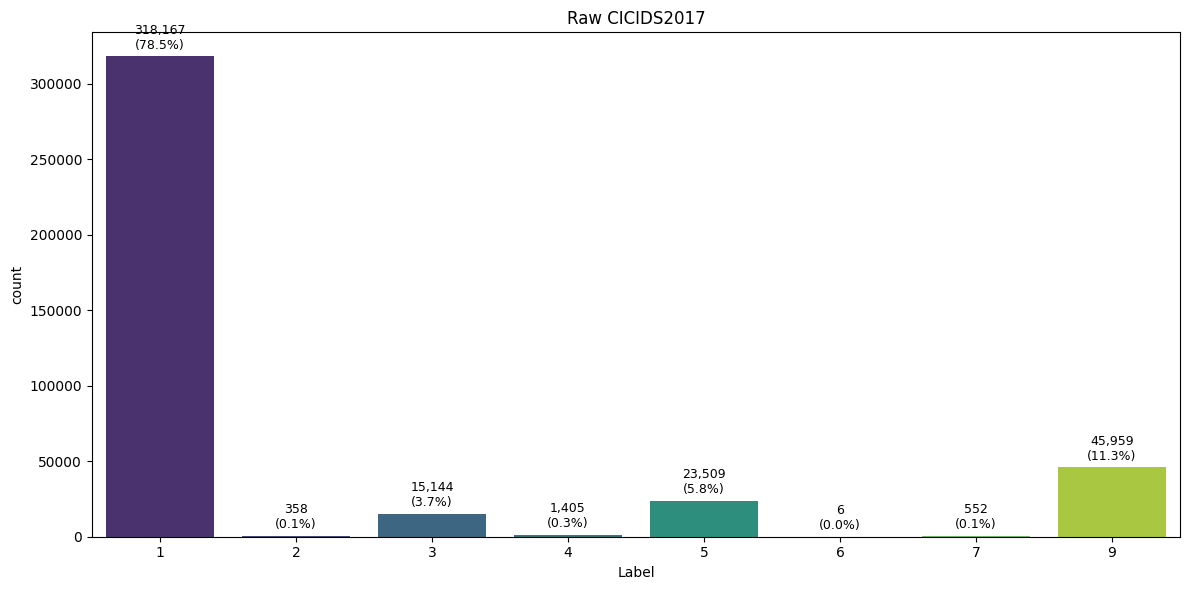

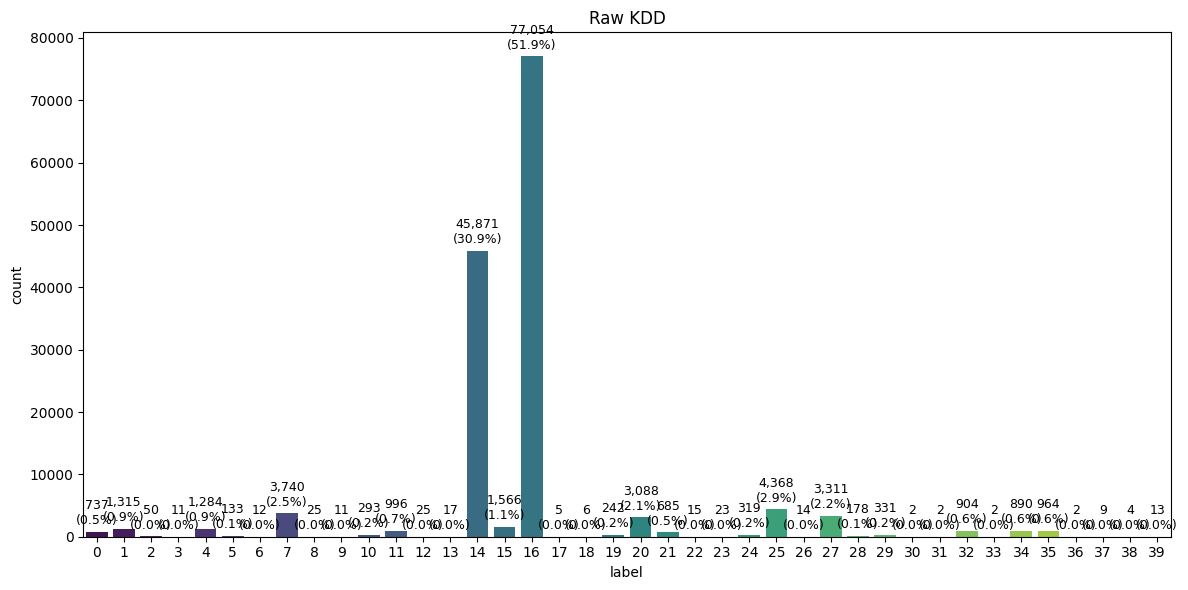

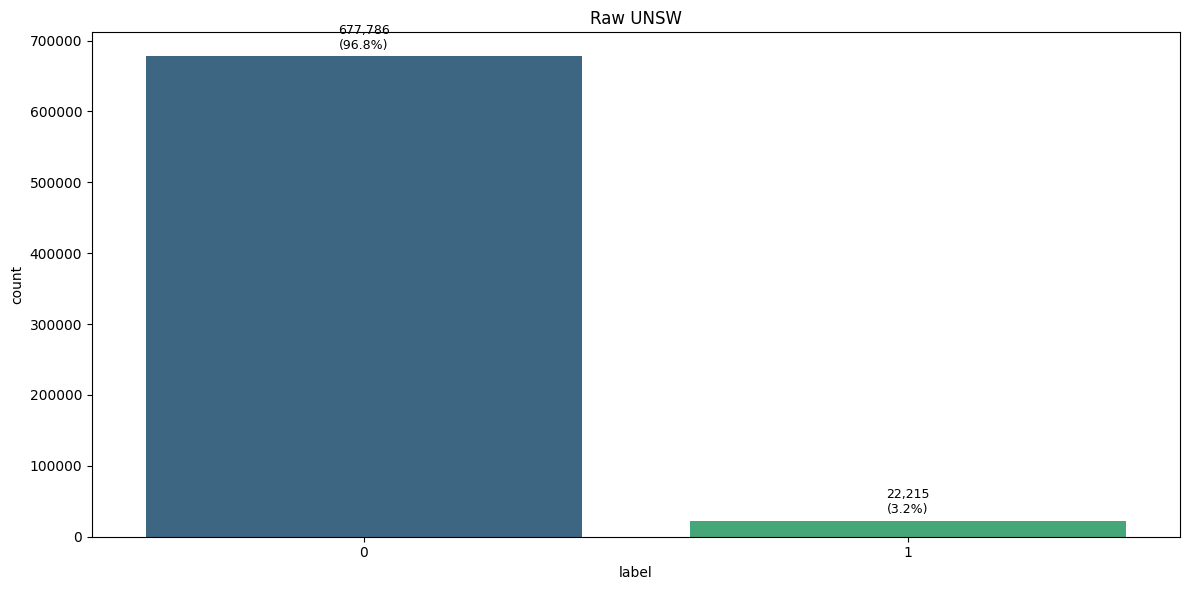

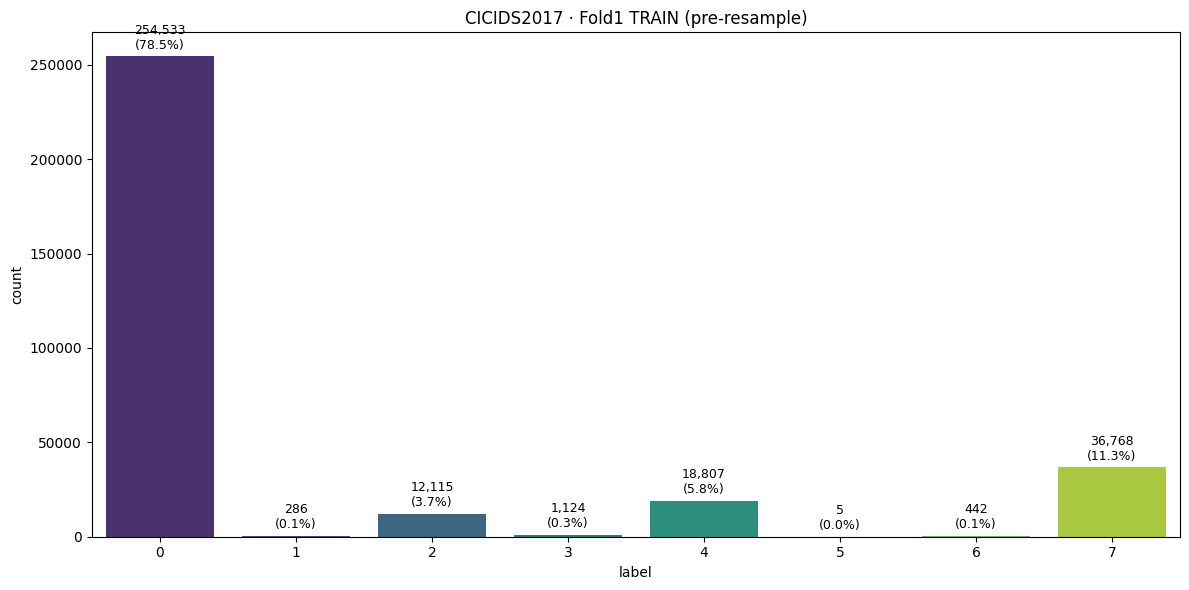

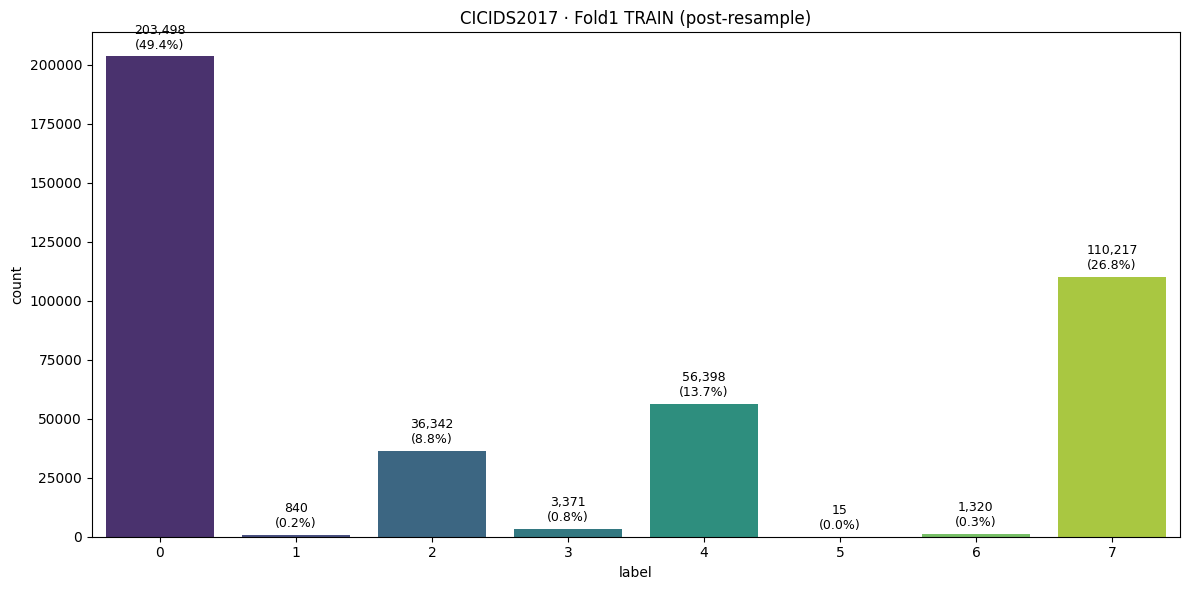

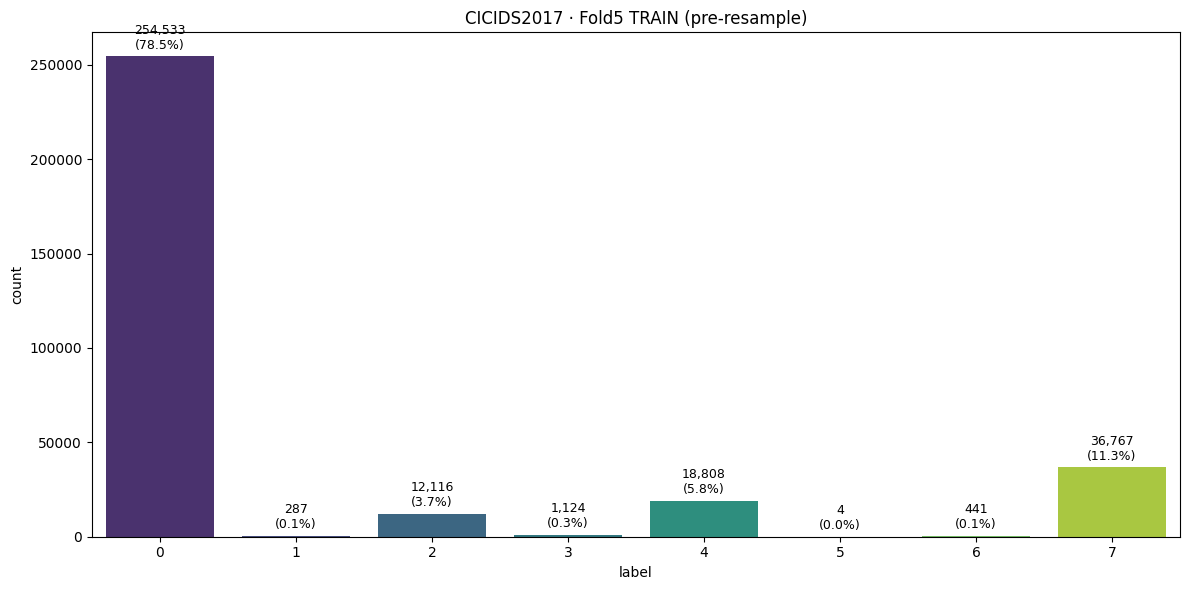

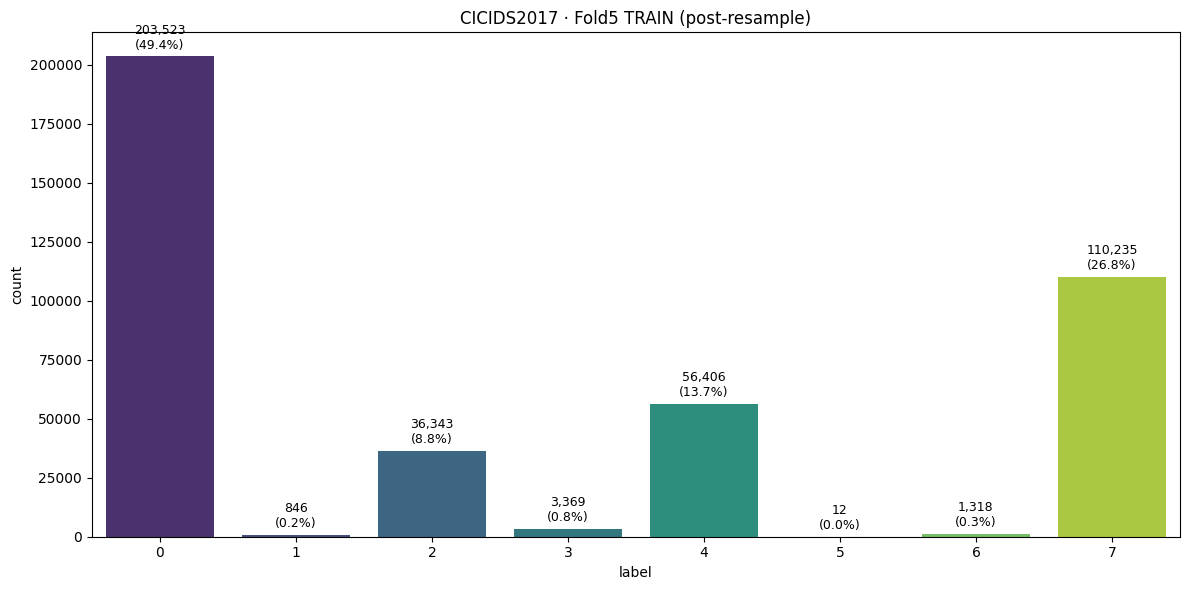

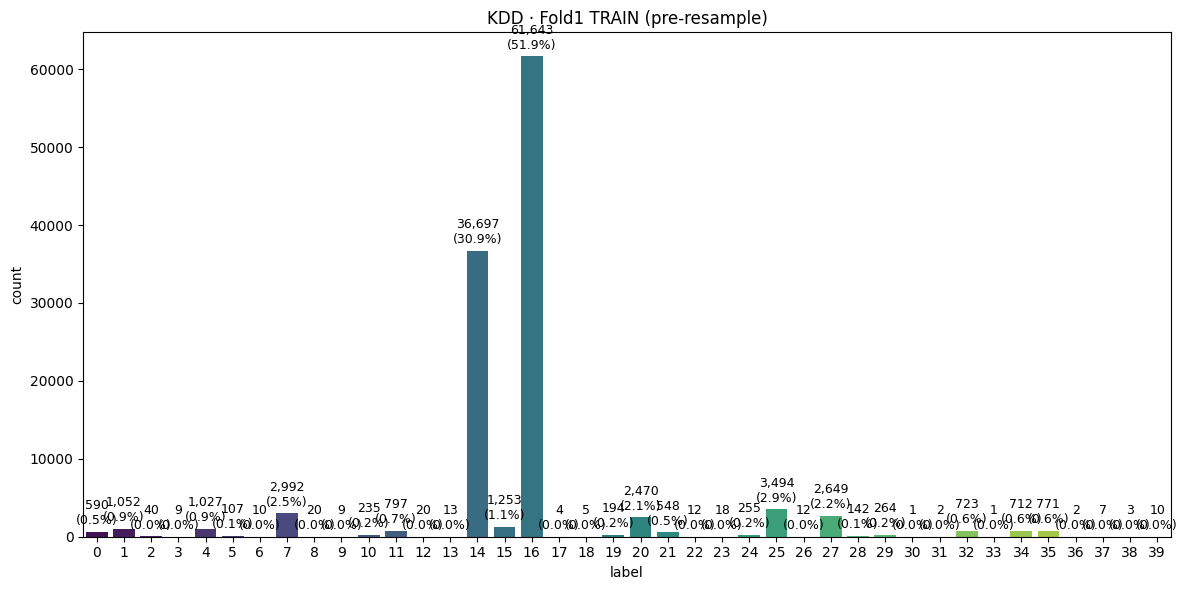

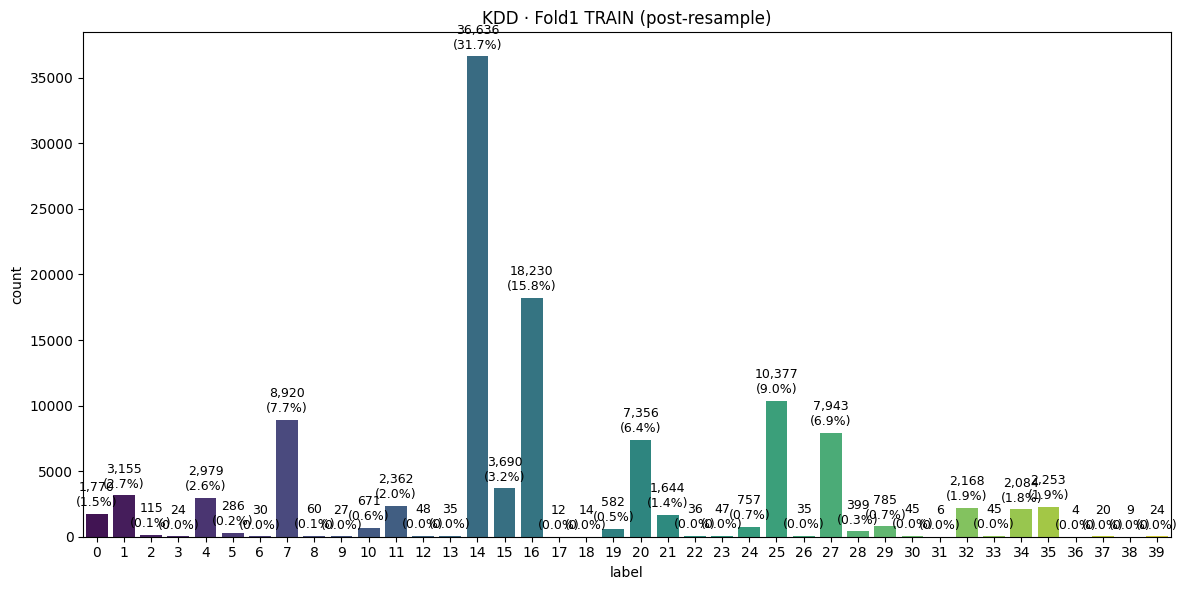

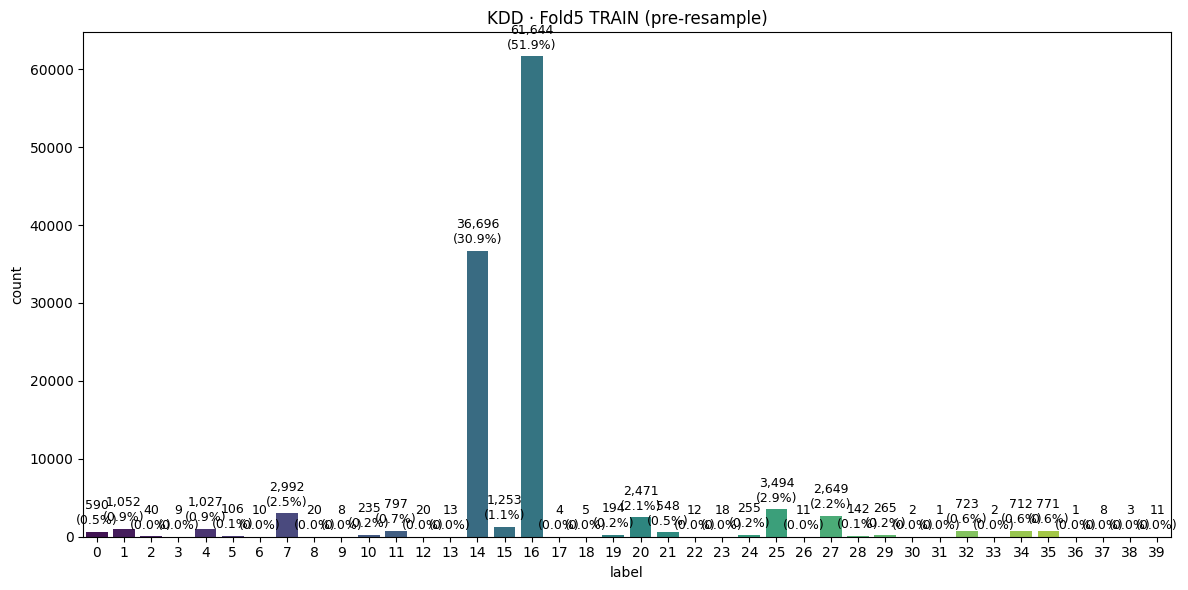

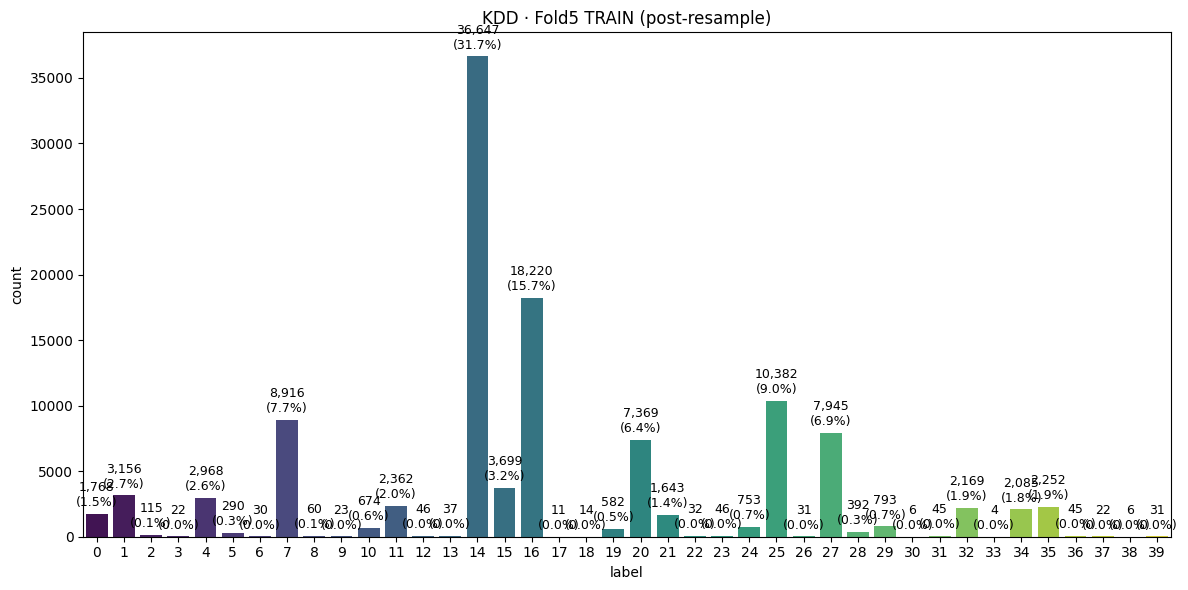

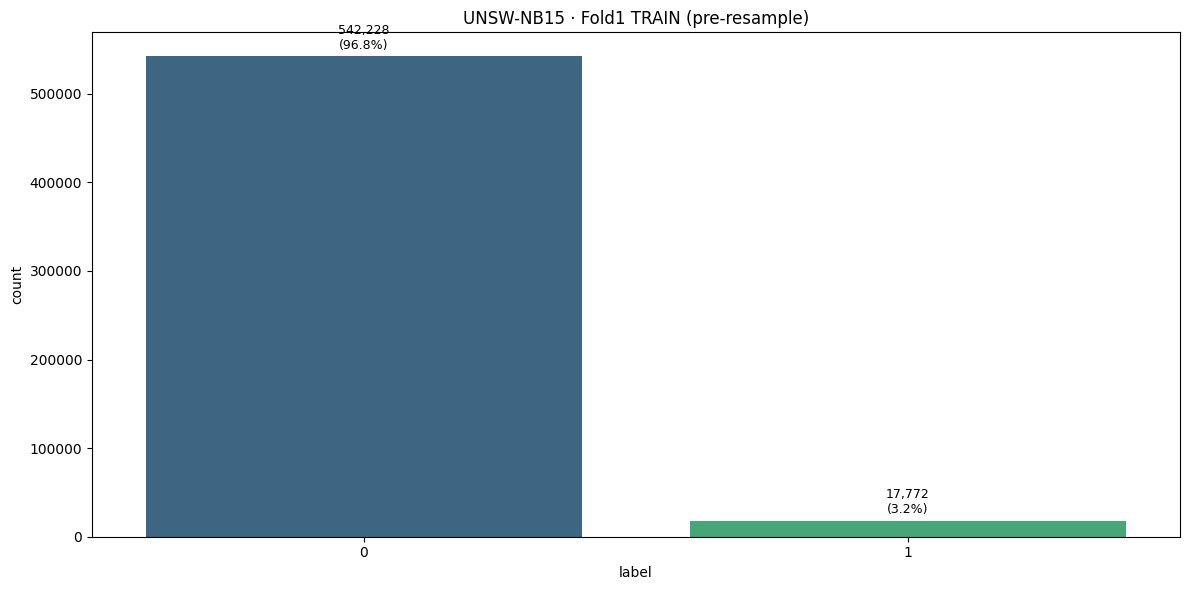

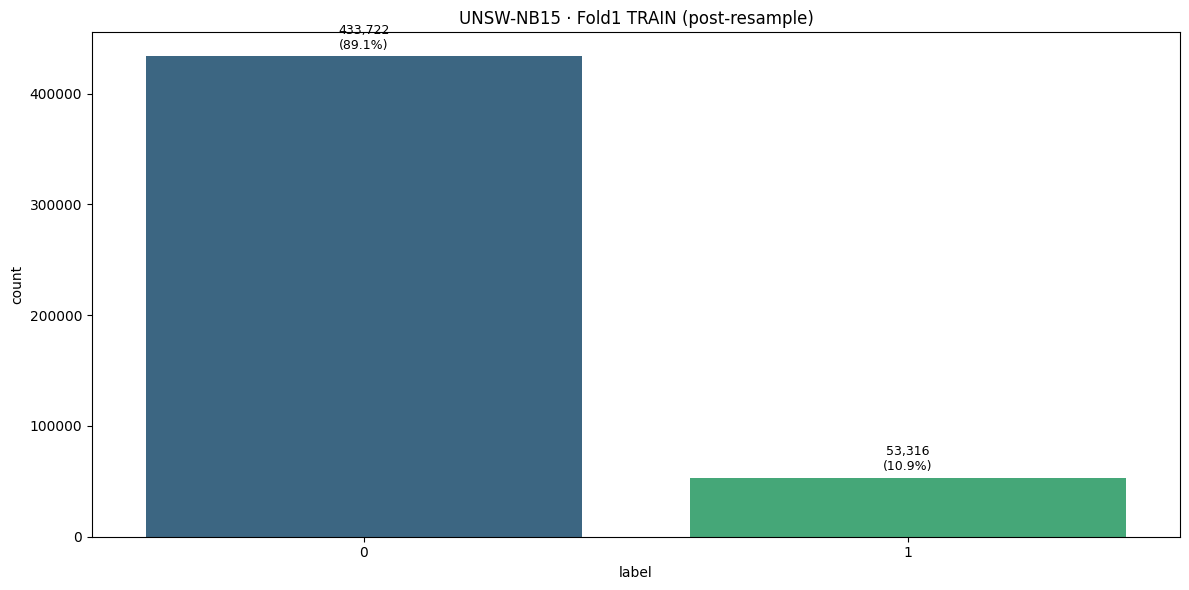

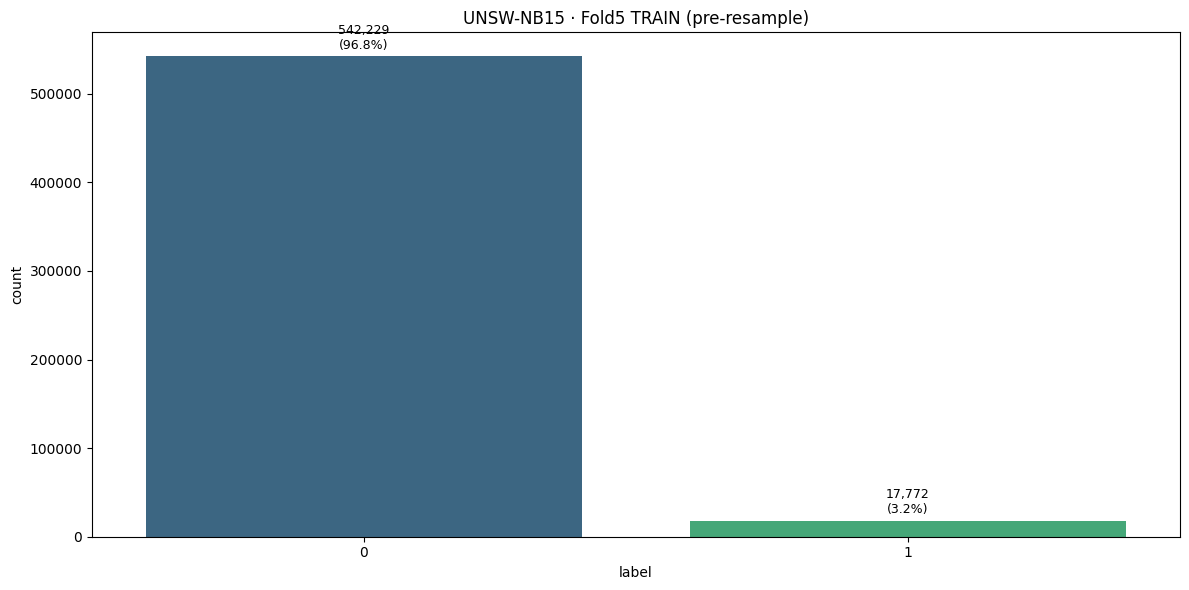

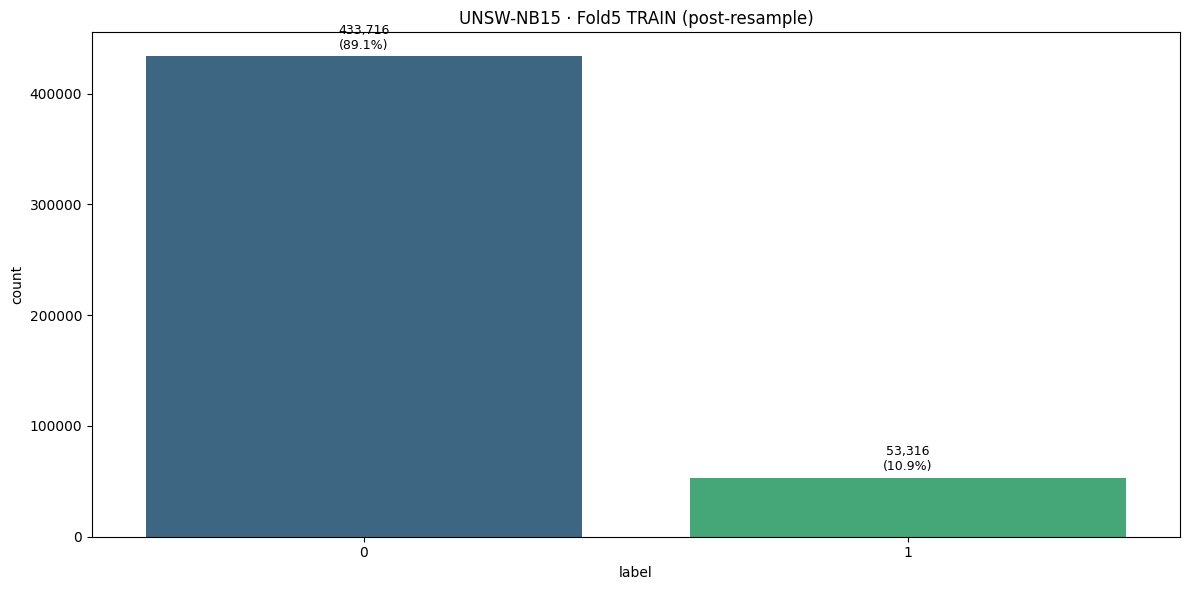

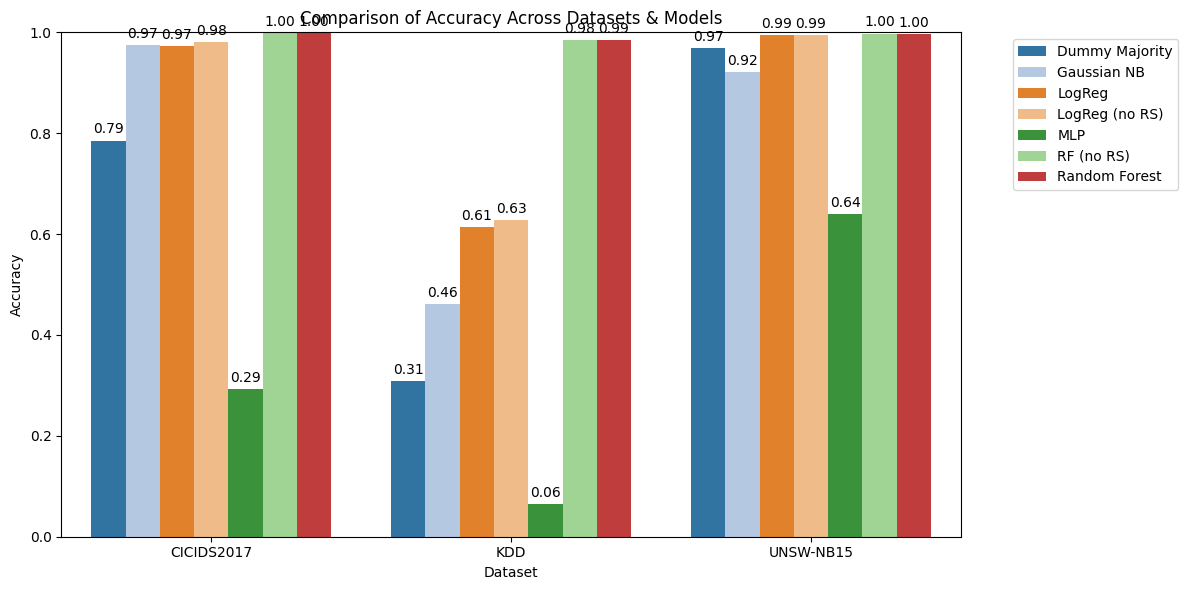

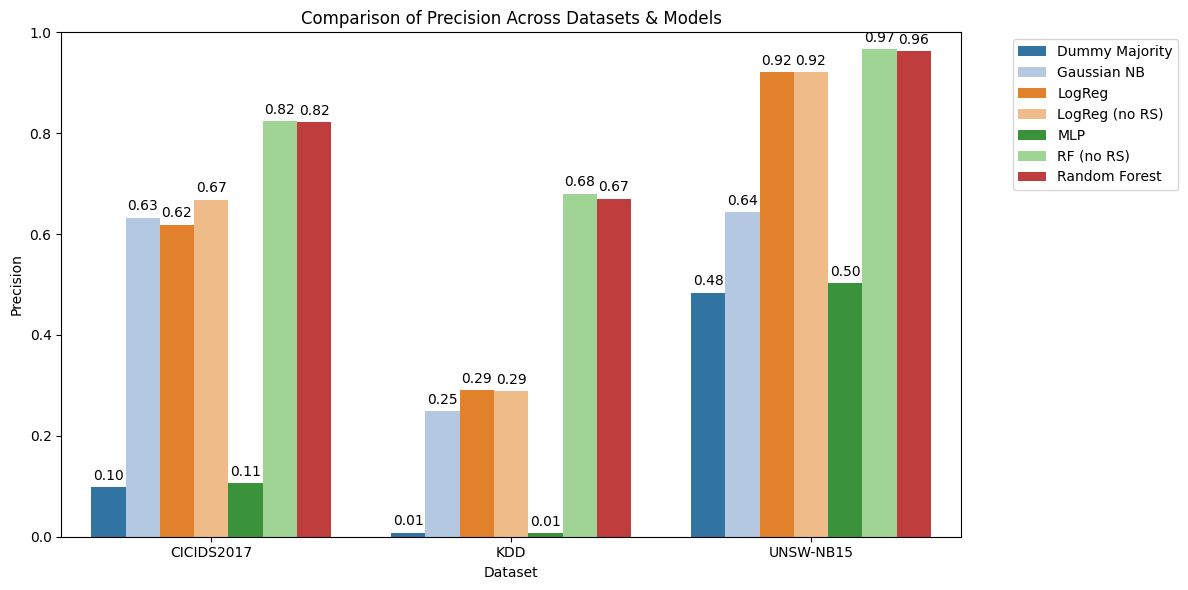

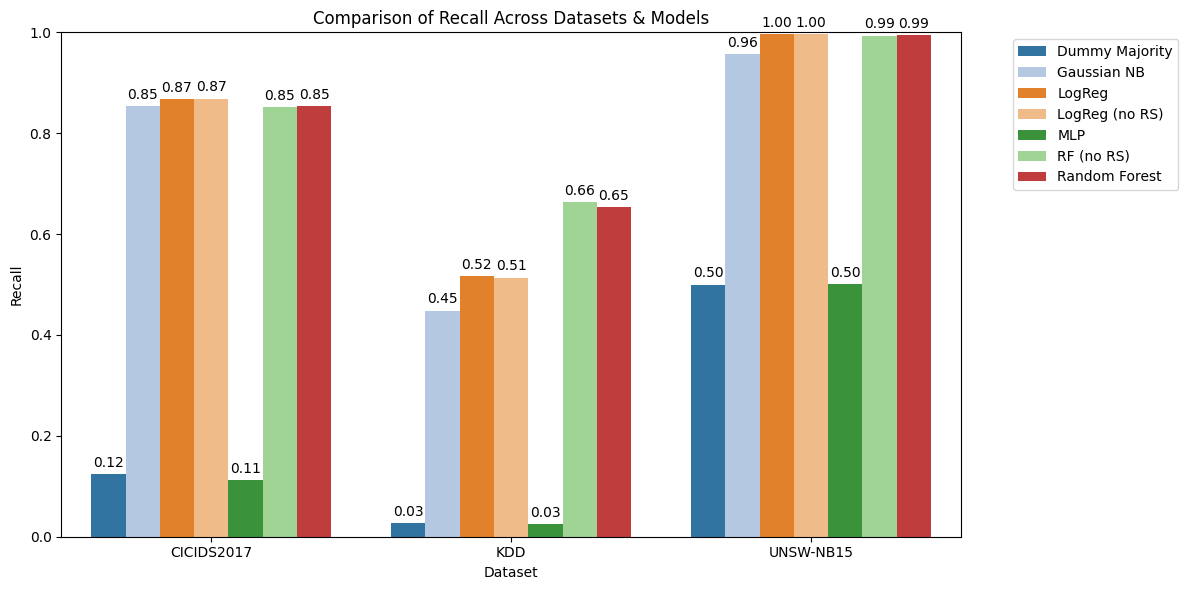

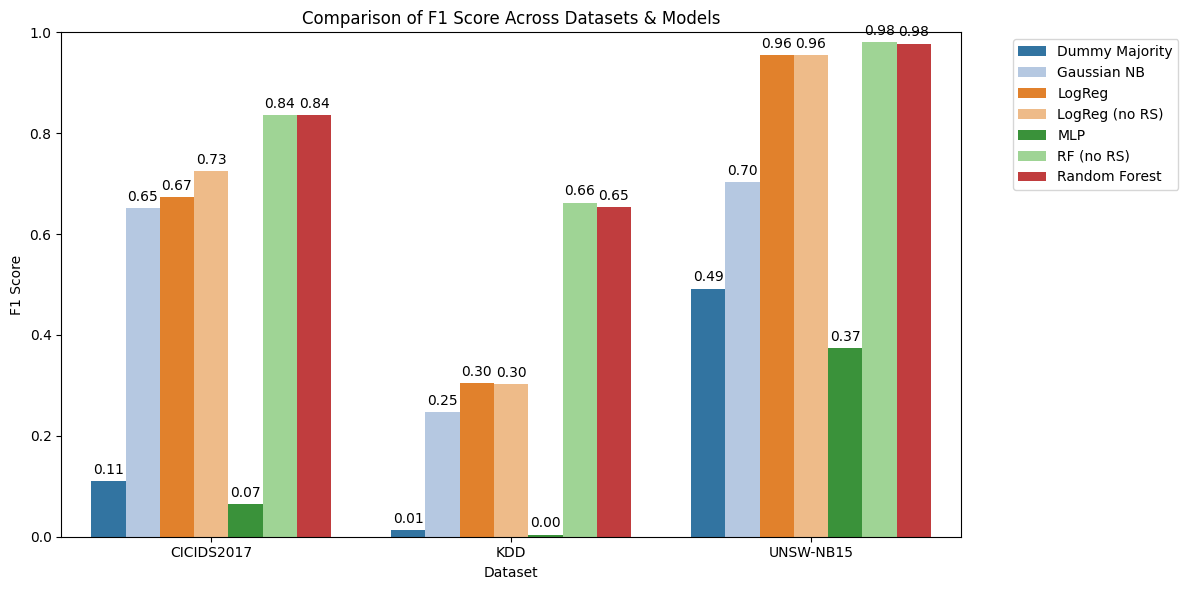

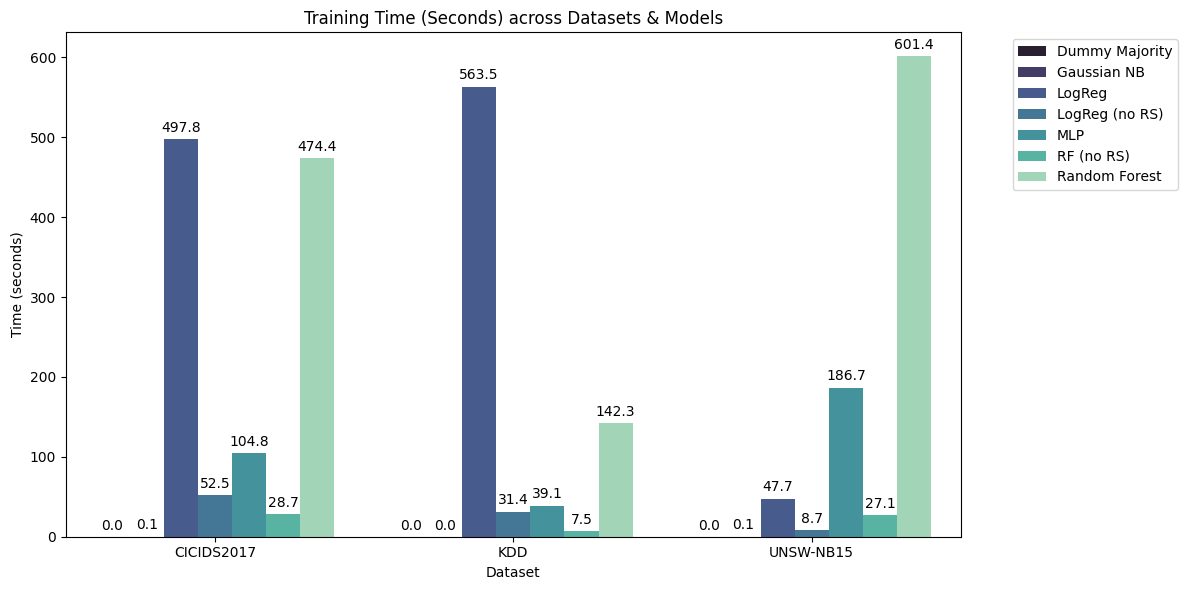

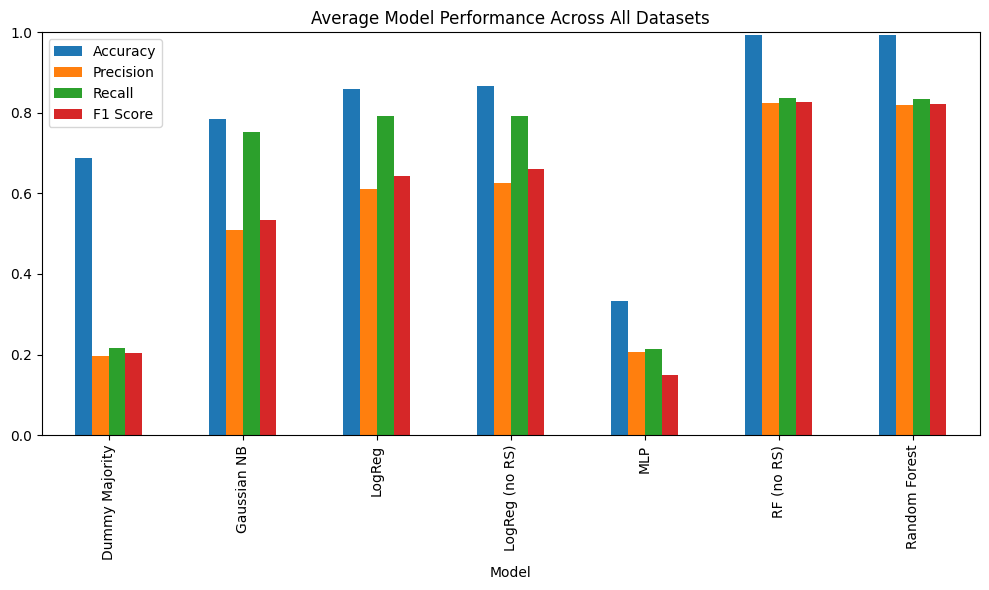

All available class reports saved to /home/cwtgl/all_class_reports.xlsx
Saved results successfully to /home/cwtgl/combined_results.csv


In [12]:
# Base directory for data and outputs
DATA_DIR = '/home/cwtgl'

# File paths
CICIDS_PATH = os.path.join(DATA_DIR, 'cleaned_and_reduced_CICIDS2017-02.csv')
KDD_PATH = os.path.join(DATA_DIR, 'combined_cleaned_KDD.csv')
UNSW_PATH = os.path.join(DATA_DIR, 'cleaned_UNSW-NB15-02.csv')


def slugify(name: str) -> str:
    """Convert spaces/exotic spaces to underscores."""
    return name.replace(' ', '_').replace('\xa0', '_')


def save_class_reports(results_dict, data_dir):
    """
    Gather class report CSVs into a single Excel workbook.
    """
    output_path = os.path.join(data_dir, 'all_class_reports.xlsx')
    with pd.ExcelWriter(output_path) as writer:
        wrote_any = False
        for ds_name, ds_results in results_dict.items():
            for model_name in ds_results:
                pattern = os.path.join(
                    data_dir,
                    f"{ds_name}-fold*_{slugify(model_name)}_class_report.csv"
                )
                for csv_file in glob.glob(pattern):
                    fold = os.path.basename(csv_file).split('_')[0].split('-')[-1]
                    sheet_name = f"{ds_name[:4]}_{fold}_{slugify(model_name)[:10]}"
                    pd.read_csv(csv_file, index_col=0).to_excel(
                        writer, sheet_name=sheet_name
                    )
                    wrote_any = True

        if not wrote_any:
            pd.DataFrame({'msg': ['no reports found']}).to_excel(
                writer, sheet_name='EMPTY'
            )

    print(f"All available class reports saved to {output_path}")


def save_combined_results(df, data_dir):
    """
    Save the combined results DataFrame to a CSV file.
    """
    out_csv = os.path.join(data_dir, 'combined_results.csv')
    df.to_csv(out_csv, index=False)
    print(f"Saved results successfully to {out_csv}")



def plot_metrics(df_all, metrics=None, palette='tab20'):
    """
    Generate bar plots for given metrics and training time.
    """
    if metrics is None:
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    # Plot each accuracy/precision/recall/F1 metric
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(
            x='Dataset', y=metric, hue='Model', data=df_all, palette=palette)
        ax.set(ylim=(0, 1), title=f'Comparison of {metric} Across Datasets & Models')
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    # Plot training times
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='Dataset', y='training_time_seconds', hue='Model', data=df_all,
        palette='mako'
    )
    ax.set(title='Training Time (Seconds) across Datasets & Models', ylabel='Time (seconds)')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Plot average model performance
    avg_perf = df_all.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean()
    avg_perf.plot.bar(figsize=(10, 6))
    plt.ylim(0, 1)
    plt.title('Average Model Performance Across All Datasets')
    plt.tight_layout()
    plt.show()



"""
Load datasets, run cross-validated workflows, combine results,
plot metrics, and save reports and combined outputs.
"""
# Load and preprocess each dataset
datasets = {
    'CICIDS2017': load_and_preprocess_cicids(CICIDS_PATH),
    'KDD': load_and_preprocess_kdd(KDD_PATH),
    'UNSW-NB15': load_and_preprocess_unsw(UNSW_PATH),
}
# Run workflows for each dataset
results = {}
for name, (X, y, _) in datasets.items():
    sampler = make_kdd_sampler if name == 'KDD' else make_realistic_resampler
    results[name] = cross_validated_workflow(
        X, y, dataset_name=name, sampler_fn=sampler
    )
# Convert DataFrames to dict-of-dicts for easy lookup
def df_to_dict(df):
    return df.pivot(index='Model', columns='Metric', values='Mean').to_dict(orient='index')
results_dict = {name: df_to_dict(df) for name, df in results.items()}
# Combine all results into a single DataFrame
records = []
for ds_name, ds_results in results_dict.items():
    for model, metrics in ds_results.items():
        records.append({
            'Dataset': ds_name,
            'Model': model,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1 Score': metrics['f1_score'],
            'training_time_seconds': metrics['training_time_seconds'],
        })
df_all = pd.DataFrame(records)
print('\nCombined Results across all Datasets:')
print(df_all)
# Plot performance metrics and training times
plot_metrics(df_all)
# Save detailed class reports and combined results CSV
save_class_reports(results_dict, DATA_DIR)
save_combined_results(df_all, DATA_DIR)


